### Fera formidável 4.3 - Derrube pra fora

#### Enunciado:
Objetivo: implemente o regularizador dropout na rede neural feita em Python puro.

Comentário: algumas tarefas vão apresentar palavras e conceitos que ainda não
vimos em sala. Parte do desafio é justamente se informar sobre estes conceitos.

Comentário 2: observe que o enunciado diz claramente que é para realizar a tarefa
na rede neural feita em Python puro nos vídeos da disciplina. Se você está usando o
PyTorch, numpy, tensorflow, keras, lightning ou qualquer outra biblioteca pronta,
você está no caminho errado!

In [22]:
import math
import random
import seaborn as sns
import random as rd
from sklearn.preprocessing import StandardScaler

In [23]:
class Valor:
    def __init__(self, data, progenitor=(), operador_mae="", rotulo=""):
        self.data = data
        self.progenitor = progenitor
        self.operador_mae = operador_mae
        self.rotulo = rotulo
        self.grad = 0

    def __repr__(self):
        return f"Valor(data={self.data})"
    
    def __add__(self, outro_valor):
        """Realiza a operação: self + outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data + outro_valor.data
        operador_mae = "+"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_adicao():
            self.grad += resultado.grad
            outro_valor.grad += resultado.grad
            
        resultado.propagar = propagar_adicao
        
        return resultado
    
    def __mul__(self, outro_valor):
        """Realiza a operação: self * outro_valor."""
        
        if not isinstance(outro_valor, Valor):
            outro_valor = Valor(outro_valor)
            
        progenitor = (self, outro_valor)
        data = self.data * outro_valor.data
        operador_mae = "*"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_multiplicacao():
            self.grad += resultado.grad * outro_valor.data # grad_filho * derivada filho em relação a mãe
            outro_valor.grad += resultado.grad * self.data
            
        resultado.propagar = propagar_multiplicacao
        
        return resultado
    
    def exp(self):
        """Realiza a operação: exp(self)"""
        progenitor = (self, )
        data = math.exp(self.data)
        operador_mae = "exp"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_exp():
            self.grad += resultado.grad * data 
        
        resultado.propagar = propagar_exp
        
        return resultado
    
    def __pow__(self, expoente):
        """Realiza a operação: self ** expoente"""
        assert isinstance(expoente, (int, float))
        progenitor = (self, )
        data = self.data ** expoente
        operador_mae = f"**{expoente}"
        resultado = Valor(data, progenitor, operador_mae)
        
        def propagar_pow():
            self.grad += resultado.grad * (expoente * self.data ** (expoente - 1))
        
        resultado.propagar = propagar_pow
        
        return resultado
    
    def __truediv__(self, outro_valor):
        """Realiza a operação: self / outro_valor"""
        return self * outro_valor ** (-1)
    
    def __neg__(self):
        """Realiza a operação: -self"""
        return self * -1
    
    def __sub__(self, outro_valor):
        """Realiza a operação: self - outro_valor"""
        return self + (-outro_valor)
    
    def __radd__(self, outro_valor):
        """Realiza a operação: outro_valor + self"""
        return self + outro_valor
    
    def __rmul__(self, outro_valor):
        """Realiza a operação: outro_valor * self"""
        return self * outro_valor
    
    def sig(self):
        """Realiza a operação: exp(self) / (exp(self) + 1)"""
        return self.exp() / (self.exp() + 1)
    
    def propagar(self):
        pass
    
    def propagar_tudo(self):
        
        self.grad = 1
        
        ordem_topologica = []
        
        visitados = set()

        def constroi_ordem_topologica(v):
            if v not in visitados:
                visitados.add(v)
                for progenitor in v.progenitor:
                    constroi_ordem_topologica(progenitor)
                ordem_topologica.append(v)

        constroi_ordem_topologica(self)
        
        for vertice in reversed(ordem_topologica):
            vertice.propagar()

In [24]:
class Neuronio:
    def __init__(self, num_dados_entrada):
        self.vies = Valor(random.uniform(-1, 1))
        
        self.pesos = []
        for i in range(num_dados_entrada):
            self.pesos.append(Valor(random.uniform(-1, 1)))
            
    def __call__(self, x):
        
        assert len(x) == len(self.pesos)
        
        soma = 0
        for info_entrada, peso_interno in zip(x, self.pesos):
            soma += info_entrada * peso_interno
            
        soma += self.vies  
        dado_de_saida = soma.sig()
        
        return dado_de_saida       
    
    def parametros(self):
        return self.pesos + [self.vies]

In [25]:
class Camada:
    def __init__(self, num_neuronios, num_dados_entrada, taxa_dropout):
        neuronios = []
        
        for _ in range(num_neuronios):
            neuronio = Neuronio(num_dados_entrada)
            neuronios.append(neuronio)
            
        self.neuronios = neuronios   
        self.taxa_dropout = taxa_dropout  
        
    def __call__(self, x, treino = True):
        dados_de_saida = []
        
        for neuronio in self.neuronios:
            informacao = neuronio(x)
            dados_de_saida.append(informacao)
            
        if treino:
            mascara = []
            for _ in self.neuronios: 
                if rd.random() > self.taxa_dropout:
                    mascara.append(1)
                else:
                    mascara.append(0)
                        
            novos_dados_saida = []
            for dado, masc in zip(dados_de_saida, mascara):
                if masc == 1:
                    novos_dados_saida.append((dado * masc)/(1 - self.taxa_dropout))
                else:
                    novos_dados_saida.append(0)
                    
            dados_de_saida = novos_dados_saida
            
        if len(dados_de_saida) == 1:
            return dados_de_saida[0]
        else:        
            return dados_de_saida  
    
    def parametros(self):
        params = []
        
        for neuronio in self.neuronios:
            params_neuronio = neuronio.parametros()
            params.extend(params_neuronio)
        
        return params

In [26]:
class MLP:
    def __init__(self, num_dados_entrada, num_neuronios_por_camada, taxa_dropout):
        
        percurso = [num_dados_entrada] + num_neuronios_por_camada
        
        camadas = []
        
        for i in range(len(num_neuronios_por_camada)):
            camada = Camada(num_neuronios_por_camada[i], percurso[i], taxa_dropout)
            camadas.append(camada)
            
        self.camadas = camadas
        
    def __call__(self, x, treino):
        for camada in self.camadas:
            x = camada(x, treino)
        return x
    
    def parametros(self):
        params = []
        
        for camada in self.camadas:
            parametros_camada = camada.parametros()
            params.extend(parametros_camada)
            
        return params

In [27]:
df = sns.load_dataset("iris")
df

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [28]:
normalizador = StandardScaler()

sepal_lenght = df["sepal_length"].values.reshape(-1,1)
sepal_width = df["sepal_width"].values.reshape(-1,1)
petal_lenght = df["petal_length"].values.reshape(-1,1)
petal_width = df["petal_width"].values.reshape(-1,1)

normalizador.fit(sepal_lenght)
normalizador.fit(sepal_width)
normalizador.fit(petal_lenght)
normalizador.fit(petal_width)

sepal_lenght = normalizador.transform(sepal_lenght)
sepal_width = normalizador.transform(sepal_width)
petal_lenght = normalizador.transform(petal_lenght)
petal_width = normalizador.transform(petal_width)

sepal_lenght = sepal_lenght.tolist()
sepal_width = sepal_width.tolist()
petal_lenght = petal_lenght.tolist()
petal_width = petal_width.tolist()

x = []
for i, j, k in zip(sepal_lenght, sepal_width, petal_lenght):
  for sep_l, sep_w, pet_l in zip(i, j, k):
    x.append([sep_l, sep_w, pet_l])
        
y_true = []
for i in petal_width:
    for j in i:
        y_true.append(j)

print(x)
print(y_true)

[[5.134532735217001, 3.028417786572188, 0.26414191647586993], [4.8712683666364, 2.370256865120684, 0.26414191647586993], [4.608003998055798, 2.6335212337012854, 0.13250973218556925], [4.476371813765497, 2.501889049410985, 0.3957741007661709], [5.002900550926701, 3.160049970862489, 0.26414191647586993], [5.529429288087905, 3.5549465237333915, 0.6590384693467726], [4.476371813765497, 2.896785602281887, 0.26414191647586993], [5.002900550926701, 2.896785602281887, 0.3957741007661709], [4.213107445184896, 2.238624680830383, 0.26414191647586993], [4.8712683666364, 2.501889049410985, 0.3957741007661709], [5.529429288087905, 3.29168215515279, 0.3957741007661709], [4.739636182346099, 2.896785602281887, 0.5274062850564719], [4.739636182346099, 2.370256865120684, 0.26414191647586993], [4.081475260894595, 2.370256865120684, -0.1307546363950324], [6.055958025249107, 3.686578708023692, 0.0008775478952682834], [5.924325840958807, 4.213107445184896, 0.3957741007661709], [5.529429288087905, 3.554946523

In [29]:
NUM_DADOS_DE_ENTRADA = 3
NUM_DADOS_DE_SAIDA = 1
CAMADAS_OCULTAS = [8, 4]  
TAXA_DROPOUT = 0.3

arquitetura_da_rede = CAMADAS_OCULTAS + [NUM_DADOS_DE_SAIDA]

minha_mlp = MLP(NUM_DADOS_DE_ENTRADA, arquitetura_da_rede, taxa_dropout=TAXA_DROPOUT)

In [30]:
NUM_EPOCAS = 100
TAXA_DE_APRENDIZADO = 0.05

x_plot = []
y_plot = []

for epoca in range(NUM_EPOCAS):
    # forward pass
    y_pred = []
    for exemplo in x:
        previsao = minha_mlp(exemplo, treino = True)
        y_pred.append(previsao)
 
    # loss
    erros = []
    for yp, yt in zip(y_pred, y_true):
        residuo = yp - yt
        erro_quadratico = residuo ** 2
        erros.append(erro_quadratico)        
    loss = sum(erros)
 
    # zero grad
    for p in minha_mlp.parametros():
        p.grad = 0
 
    # backpropagation
    loss.propagar_tudo()
 
    # atualiza parâmetros
    for p in minha_mlp.parametros():
        p.data = p.data - p.grad * TAXA_DE_APRENDIZADO
 
    # mostra resultado (opcional)
    print(epoca, loss.data)
    
    x_plot.append(epoca)
    y_plot.append(loss.data)

0 168.0003188295405
1 150.35185805718203
2 150.0975542703431
3 151.5409747712695
4 150.13657681982195
5 150.2713521451811
6 150.8530768929469
7 150.5940488678273
8 150.17456552922536
9 149.5833059562826
10 149.93357986104218
11 149.76883580755586
12 149.71870983899976
13 150.16075376653927
14 150.15361855675286
15 149.75374169644138
16 149.4784227569956
17 150.51740130276053
18 149.6554814240277
19 149.56327003264613
20 150.16485977634642
21 149.78698302979947
22 150.34198707957907
23 149.96982529355142
24 149.98785132973998
25 149.83542337575784
26 150.41921832045014
27 149.6895625818826
28 149.57041985804904
29 150.97577652275928
30 150.13920911860797
31 150.14387851311062
32 149.4025752718468
33 150.71539802205956
34 150.1338944381796
35 149.994895154313
36 149.70122061114853
37 149.36199435659537
38 150.09372827712687
39 149.65116184152987
40 149.94019104028865
41 150.40927586967365
42 150.75718958511317
43 149.99464878306352
44 149.8695658148268
45 149.4075883091852
46 150.1158813

116.7652370902434


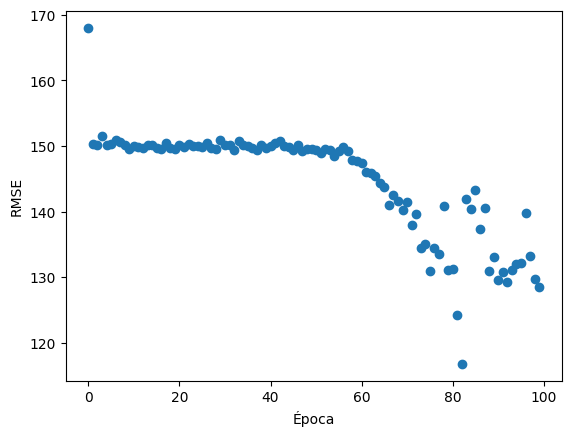

In [31]:
import matplotlib.pyplot as plt 

plt.scatter(x_plot, y_plot)
plt.xlabel("Época")
plt.ylabel("RMSE")

print(min(y_plot))

In [32]:
y_true

[-1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.0521799264271385,
 -1.1838121107174393,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.4470764792980408,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.4470764792980408,
 -1.4470764792980408,
 -1.3154442950077403,
 -1.0521799264271385,
 -1.0521799264271385,
 -1.1838121107174393,
 -1.1838121107174393,
 -1.1838121107174393,
 -1.3154442950077403,
 -1.0521799264271385,
 -1.3154442950077403,
 -0.9205477421368377,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.0521799264271385,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.0521799264271385,
 -1.4470764792980408,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.4470764792980408,
 -1.3154442950077403,
 -1.3154442950077403,
 -1.1838121107174393,
 -1.1838121107174393,
 -1.3154442950077403,
 -0.7889155578465368,
 -1.0521799264271385,
 -1.183812

In [33]:
y_pred

[Valor(data=0.0018019995259120152),
 Valor(data=6.098591207208453e-05),
 0,
 Valor(data=0.06677312942077336),
 Valor(data=0.3267379363252494),
 Valor(data=0.00735761167926327),
 Valor(data=0.002299566362068034),
 Valor(data=0.0025456380811578905),
 0,
 Valor(data=0.007474419524381633),
 0,
 Valor(data=0.0072557825594904025),
 Valor(data=6.651252687895757e-05),
 Valor(data=0.37060135686316864),
 0,
 Valor(data=0.0571946266957897),
 0,
 Valor(data=0.002457875407557052),
 Valor(data=0.0010328834028298503),
 0,
 0,
 0,
 0,
 0,
 Valor(data=0.0018323268913777177),
 Valor(data=6.751718880094963e-05),
 Valor(data=0.0011322606806047483),
 Valor(data=0.0757303783673131),
 0,
 Valor(data=0.001142363148403899),
 Valor(data=0.002600728452582993),
 0,
 0,
 0,
 Valor(data=0.013110630841152172),
 0,
 Valor(data=0.6083218640159441),
 Valor(data=0.14280797113016566),
 Valor(data=6.55974025429814e-05),
 Valor(data=0.00021605857334630453),
 Valor(data=6.423280046052408e-05),
 Valor(data=0.0230351756272859